In [1]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
import pandas as pd

# grab the StructureTree instance
structure_tree = mcc.get_structure_tree()

### Generate list of edges arising in the hypothalmus
If it's in the hypothalamus, and it starts an edge, it's here.

In [2]:
# Get hypothalamus information
hy = structure_tree.get_structures_by_acronym(['HY'])[0]
# Get hypothalmus experiments
hy_experiments = mcc.get_experiments(injection_structure_ids=[hy['id']])

print("%d HY experiments" % len(hy_experiments))

# Organize our columns all nice like for retrieval from structure_unionizes
cols = ['experiment_id', 'id','origin_abbrev', 'origin_id', 'target_abbrev', 'target_id', 'is_injection',
       'max_voxel_density', 'max_voxel_x', 'max_voxel_y', 'max_voxel_z',
       'normalized_projection_volume', 'projection_density',
       'projection_energy', 'projection_intensity', 'projection_volume',
       'sum_pixel_intensity', 'sum_pixels',
       'sum_projection_pixel_intensity', 'sum_projection_pixels', 'volume'
       ]
unionizes = pd.DataFrame(columns=cols)
# Grab unionizes for all hypothalmus experiments (all origin nodes will be in the hypothalmus, target nodes will be anywhere)
for exp in hy_experiments:
    # Go one experiment at a time, getting info on what happened after an injection to the "experiment['structure_id']" site
    # ASSUMING that the "structure_id" listed for an experiment is the STARTING NODE of an edge
    structure_unionizes = mcc.get_structure_unionizes([exp['id']],  # Experiment ID
                                                      is_injection=True,  # only return unionize records that include injection pixels
                                                      include_descendants=True,
                                                      hemisphere_ids=[3])  # Get data from both left and right hemispheres
    structure_unionizes['origin_abbrev'] = exp['structure_abbrev']  # acronym for primary injection site
    structure_unionizes['origin_id'] = exp['structure_id']  # ID for primary injection site
    structure_unionizes['target_id'] = structure_unionizes['structure_id']  # Resultant target of injection (n2)
    structure_unionizes['target_abbrev'] = ""  # Save for later
    # Put columns in right order
    structure_unionizes = structure_unionizes[cols]
    # Add this unionize to overall dataframe
    unionizes = unionizes.append(structure_unionizes)

print("%d HY injection unionizes" % len(structure_unionizes))
# Reorganize experiment list into dataframe
hy_experiments = mcc.get_experiments(injection_structure_ids=[hy['id']],
                                     dataframe=True)

258 HY experiments
47 HY injection unionizes


### Sorted hypothalamic injections
With *origin node* (where injection took place, i.e. n1) and *target node* (where the injection ended / where the characteristics are described, i.e. n2).

The data *almost* matches Ahmad's? Looks like I have some extra edges (ex. 693 -> 1004)

In [3]:
# Add acronyms for target IDs
unionizes['target_abbrev'] = unionizes.apply(lambda x: structure_tree.get_structures_by_id([x['target_id']])[0]['acronym'], axis=1)
unionizes.sort_values(by=['projection_intensity'], ascending=False).head()

,experiment_id,id,origin_abbrev,origin_id,target_abbrev,target_id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,...,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume
2,313325371,634205213,VMH,693,PMv,1004,True,1.000000,7530,6680,...,0.106217,0.999797,15681.265950,15684.446912,0.104063,1.332621e+12,8.496624e+07,1.332378e+12,8.494901e+07,0.104084
30,180674463,630259390,AHN,88,ASO,332,True,1.000000,6120,6240,...,0.002448,1.000000,15607.258483,15607.258483,0.003425,4.364258e+10,2.796300e+06,4.364258e+10,2.796300e+06,0.003425
28,264320076,630880636,TU,614,PMv,1004,True,1.000000,7460,6580,...,0.109980,0.999935,14983.580888,14984.558083,0.084149,1.029361e+12,6.869749e+07,1.029334e+12,6.869301e+07,0.084154
4,158258062,628586309,VMH,693,sup,349,True,0.818368,6610,6800,...,0.000104,0.999930,14964.597403,14965.643477,0.000153,1.863393e+09,1.245111e+05,1.863259e+09,1.245024e+05,0.000153
49,181057754,630439683,AHN,88,ASO,332,True,1.000000,6190,6280,...,0.002248,1.000000,14775.557942,14775.557942,0.003425,4.131689e+10,2.796300e+06,4.131689e+10,2.796300e+06,0.003425


#### Make the table pretty and display as hypothalamus edges w/ intensities

In [4]:
hy_edges = unionizes.sort_values(by=['projection_intensity'], ascending=False)
# If there's a duplicate, drop all but the most intense one
hy_edges = hy_edges.drop_duplicates(subset=['origin_id', 'target_id'], keep='first')
# Remove self-loops
hy_edges = hy_edges.loc[hy_edges['origin_id'] != hy_edges['target_id']]
# Make a more readable table with top 50% intensities
hy_edges = hy_edges.iloc[:round(hy_edges.shape[0] / 2)][['origin_abbrev', 'origin_id', 'target_abbrev', 'target_id', 'projection_intensity']]
print('There are %d HY edges' % hy_edges.shape[0])
hy_edges.head()

There are 886 HY edges


,origin_abbrev,origin_id,target_abbrev,target_id,projection_intensity
2,VMH,693,PMv,1004,15684.446912
30,AHN,88,ASO,332,15607.258483
28,TU,614,PMv,1004,14984.558083
4,VMH,693,sup,349,14965.643477
6,VMH,693,mfsbshy,824,14410.654546


In [5]:
hy_edges.to_csv('./escape edges graphs/hy edge list.csv', index=False)

When the HY is broken down completely, the ABA says there are 91 nodes that are constituents of the hypothalamus. But only 26 nodes are injected into or have edges arising from them, which sounds more reasonable so I'm using those 26.

In [6]:
"""# Get list of nodes in hypothalamus
# This gives you 91 nodes but only 26 nodes are actual injeciton sites?? Are the others just insignificant?
d = structure_tree.descendants([1097])[0]
hy_nodes = []
for region in d:
    hy_nodes.append(region['id'])
print(len(hy_nodes))"""

"# Get list of nodes in hypothalamus\n# This gives you 91 nodes but only 26 nodes are actual injeciton sites?? Are the others just insignificant?\nd = structure_tree.descendants([1097])[0]\nhy_nodes = []\nfor region in d:\n    hy_nodes.append(region['id'])\nprint(len(hy_nodes))"

#### Create 2 groups of hypothalamic edges
Escape edges : Edges which start in the hypothalamus and **leave**


Nonescape edges : Edges that start in the hypothalamus and **end there**

In [7]:
# Find list of edges that escape the hypothalamus and those that stay in hypothalmus
hy_nodes = list(hy_edges['origin_id'].unique())
escape_edges = hy_edges.loc[~hy_edges['target_id'].isin(hy_nodes)]
nonescape_edges = hy_edges.loc[hy_edges['target_id'].isin(hy_nodes)]

In [8]:
# Read problem node list from CSV
problem_nodes = pd.read_csv('../../spreadsheets/Hypothalamic Optimization counts.csv')
problem_nodes = problem_nodes.loc[problem_nodes['structure-id'].isin(hy_nodes)]
# For each node, count up # of escape edges it participates in
problem_nodes['escape edges'] = problem_nodes.apply(lambda row: escape_edges.loc[escape_edges['origin_id'] == row['structure-id']].shape[0], axis=1)
# For each node, count up # of nonescape edges it participates in
problem_nodes['nonescape edges'] = problem_nodes.apply(lambda row: nonescape_edges.loc[nonescape_edges['origin_id'] == row['structure-id']].shape[0], axis=1)
# Idk if this is useful, but calculate ratio of escape edges : nonescape edges
problem_nodes['escape edges per nonescape edge'] = problem_nodes['escape edges'] / problem_nodes['nonescape edges']
problem_nodes.head()

,structure-id,structure-abbrev,structure-name,Counts in distance>5,escape edges,nonescape edges,escape edges per nonescape edge
0,194,LHA,Lateral hypothalamic area,7,37,10,3.700000
1,491,MM,Medial mammillary nucleus,6,62,8,7.750000
2,88,AHN,Anterior hypothalamic nucleus,6,59,13,4.538462
3,830,DMH,Dorsomedial nucleus of the hypothalamus,6,39,9,4.333333
4,210,LM,Lateral mammillary nucleus,5,14,5,2.800000


#### Plot showing problem nodes with the # of edges they participate in with a poorly optimized solution, compared to # of escape edges that node has

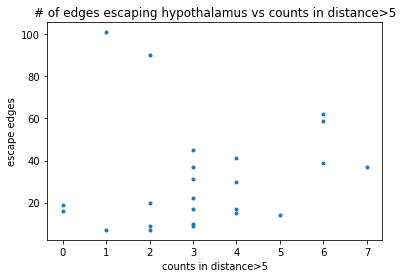

In [9]:
import matplotlib.pyplot as plt
plt.scatter(problem_nodes['Counts in distance>5'],problem_nodes['escape edges'], marker='.')
plt.ylabel('escape edges')
plt.xlabel('counts in distance>5')
plt.title('# of edges escaping hypothalamus vs counts in distance>5')
plt.savefig('./escape edges graphs/escape edges vs counts in distance.png')
plt.show()

In [10]:
# Get edge list with optimization distances
edges_df = pd.read_csv('../../spreadsheets/Hypothalamic Optimization Distances.csv')
edges_df['distance from true'] = abs(edges_df['distance from true'])
#edges_df.head(5)

In [11]:
def check_zero(a):
    if a == 0:
        return 1
    else:
        return a

In [12]:
# Get the average distance from true for each node by summing up all its distances in every node it participates in
dft_df = pd.DataFrame((edges_df.groupby(['n1'])['distance from true'].sum() + edges_df.groupby(['n2'])['distance from true'].sum()).rename('avg dft'))
problem_nodes = problem_nodes.merge(dft_df, left_on='structure-id', right_on='n1')
# Then divide by the number of edges it's in to get the average
problem_nodes['avg dft'] =  problem_nodes.apply(lambda x: x['avg dft'] / check_zero(edges_df.loc[(edges_df['n1'] == x['structure-id']) | (edges_df['n2'] == x['structure-id'])].shape[0]), axis=1)
problem_nodes

,structure-id,structure-abbrev,structure-name,Counts in distance>5,escape edges,nonescape edges,escape edges per nonescape edge,avg dft
0,194,LHA,Lateral hypothalamic area,7,37,10,3.700000,2.818766
1,491,MM,Medial mammillary nucleus,6,62,8,7.750000,2.859492
2,88,AHN,Anterior hypothalamic nucleus,6,59,13,4.538462,2.946467
3,830,DMH,Dorsomedial nucleus of the hypothalamus,6,39,9,4.333333,2.890278
4,210,LM,Lateral mammillary nucleus,5,14,5,2.800000,2.724984
5,1004,PMv,Ventral premammillary nucleus,4,30,10,3.000000,2.408345
6,515,MPN,Medial preoptic nucleus,4,41,5,8.200000,2.597151
7,126,PVp,"Periventricular hypothalamic nucleus, posterio...",4,17,7,2.428571,2.371266
8,525,SUM,Supramammillary nucleus,4,15,3,5.000000,2.046099
9,693,VMH,Ventromedial hypothalamic nucleus,3,45,16,2.812500,1.801693


#### Plot showing the # of escape edges a node has vs it's average optimized distance from true

In [20]:
from sklearn.linear_model import LinearRegression
x_dft = pd.DataFrame(problem_nodes['avg dft'])
y_esc = pd.DataFrame(problem_nodes['escape edges'])
reg = LinearRegression().fit(x_dft,y_esc)
r2 = 'R\u00b2 = ' + str(round(reg.score(x_dft,y_esc), 6))
y_pred = reg.predict(x_dft)
y_hat = '\u0177 = ' + str(round(reg.coef_[0][0], 6)) + 'x +' + str(round(*reg.intercept_, 6))

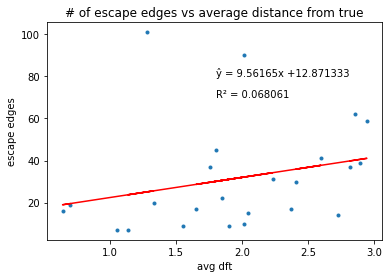

In [22]:
plt.scatter(x_dft,y_esc, marker='.')
plt.plot(x_dft, y_pred, color='red')
plt.text(1.8, 70, r2)
plt.text(1.8, 80, y_hat)
plt.ylabel('escape edges')
plt.xlabel('avg dft')
plt.title('# of escape edges vs average distance from true')
plt.savefig('./escape edges graphs/escape edges vs avg dft.png')
plt.show()

#### The zona incerta is that point at the very top so I tried removing it:

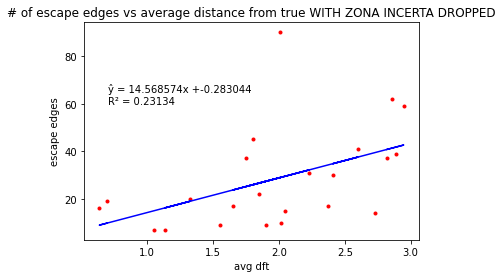

In [25]:
x_dft = pd.DataFrame(problem_nodes['avg dft'].drop([20]))
y_esc = pd.DataFrame(problem_nodes['escape edges'].drop([20]))
reg = LinearRegression().fit(x_dft,y_esc)
r2 = 'R\u00b2 = ' + str(round(reg.score(x_dft,y_esc), 6))
y_pred = reg.predict(x_dft)
y_hat = '\u0177 = ' + str(round(reg.coef_[0][0], 6)) + 'x +' + str(round(*reg.intercept_, 6))
plt.scatter(x_dft,y_esc, marker='.', color='red')
plt.plot(x_dft, y_pred, color='blue')
plt.text(.7, 60, r2)
plt.text(.7, 65, y_hat)
plt.ylabel('escape edges')
plt.xlabel('avg dft')
plt.title('# of escape edges vs average distance from true WITH ZONA INCERTA DROPPED')
plt.savefig('./escape edges graphs/escape edges vs avg dft no ZI.png')
plt.show()

#### Plot showing $\frac{\text{# escape edges}}{\text{# nonescape edges}}$ versus average optimized distance from true

In [27]:
from sklearn.linear_model import LinearRegression
x_dft = pd.DataFrame(problem_nodes['avg dft'])
y_esc = pd.DataFrame(problem_nodes['escape edges per nonescape edge'].replace([pd.np.inf, -pd.np.inf], 0))
reg = LinearRegression().fit(x_dft,y_esc)
r2 = 'R\u00b2 = ' + str(round(reg.score(x_dft,y_esc), 6))
y_pred = reg.predict(x_dft)
y_hat = '\u0177 = ' + str(round(reg.coef_[0][0], 6)) + 'x +' + str(round(*reg.intercept_, 6))

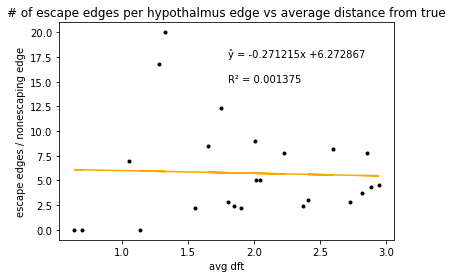

In [28]:
plt.scatter(x_dft,y_esc, marker='.', color='black')
plt.plot(x_dft, y_pred, color='orange')
plt.text(1.8, 15, r2)
plt.text(1.8, 17.5, y_hat)
plt.ylabel('escape edges / nonescaping edge')
plt.xlabel('avg dft')
plt.title('# of escape edges per hypothalmus edge vs average distance from true')
plt.savefig('./escape edges graphs/escape edge ratio vs avg dft.png')
plt.show()

## Notes
This is only with edges that arise in the hypothalamus and project somewhere else in the brain. May be different if we include all edges that connect elsewhere in the brain to the hypothalamus?